In [1]:
import operator
import math
import random
import matplotlib.pyplot as plt

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

C:\Users\Péricles\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [2]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [4]:
def evalSymbReg(individual, input_points, output_points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    sqerrors = (((func(x) - y)**2) for x, y in zip(input_points, output_points))
    return math.fsum(sqerrors) / len(input_points),

In [5]:
input_points = [x/10. for x in range(-10,10)]
output_points = [random.uniform(1,10) for x in range(-10,10)]

toolbox.register("evaluate", evalSymbReg, input_points=input_points, output_points=output_points)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [6]:
def main():
    random.seed(318)

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 1500, stats=mstats,
                                   halloffame=hof, verbose=True)
    
    return pop, log, hof

In [7]:
def plot(candidate_function):
        
        x_values = [x/10. for x in range(-10,10)]
        
        candidate_points = []
        
        for value in x_values:
            candidate_points.append(candidate_function(value))
        
        plt.plot(x_values, candidate_points, 'r')
        plt.show()

   	      	            fitness            	              size             
   	      	-------------------------------	-------------------------------
gen	nevals	avg    	max    	min    	std    	avg 	max	min	std    
0  	50    	23.1175	34.8035	15.4201	5.01283	3.82	7  	2  	1.76284
1  	30    	21.6987	36.9569	15.4201	4.89884	3.36	7  	2  	1.32303
2  	25    	19.3545	34.8035	15.4201	4.8659 	3.22	5  	1  	0.965194
3  	32    	17.9777	28.6387	15.4201	3.30997	3.46	6  	2  	1.13508 
4  	36    	18.6717	32.5065	15.4201	3.91864	3.38	7  	2  	0.997798
5  	27    	17.4451	25.0602	10.3904	3.06371	3.7 	8  	2  	1.37477 
6  	30    	17.385 	26.074 	10.3904	3.47273	3.62	10 	1  	1.5734  
7  	28    	17.4752	32.5065	10.3904	5.04314	3.2 	7  	1  	0.894427
8  	25    	17.2173	32.5065	9.8769 	5.48608	3.22	9  	1  	1.15395 
9  	25    	15.5881	27.1137	9.8769 	4.64979	3.34	9  	2  	1.30553 
10 	24    	15.3926	25.0602	9.8769 	5.04178	3.38	9  	3  	1.30981 
11 	18    	13.2103	25.1585	9.8769 	4.46808	4.84	11 	3  	2.62572 
12 	27  

126	32    	6.56366	32.5065	4.60936	4.53509 	32.88	71 	3  	15.9269 
127	38    	5.50329	18.7248	4.53625	2.22276 	31.66	56 	5  	13.2403 
128	27    	5.5638 	20.9312	4.5242 	3.14127 	34.04	65 	7  	14.804  
129	25    	5.47595	10.3904	4.5242 	1.50398 	32.06	65 	3  	12.9529 
130	30    	5.22706	17.317 	4.5242 	1.896   	31.98	64 	7  	13.6887 
131	25    	5.36091	12.1247	4.5242 	1.61447 	30.98	64 	13 	12.425  
132	32    	5.76139	22.292 	4.5242 	2.99678 	31.98	69 	3  	16.0181 
133	20    	4.83831	6.63825	4.50369	0.519728	36.68	65 	9  	13.6139 
134	16    	5.02523	15.4201	4.37333	1.84455 	42.52	62 	3  	14.9    
135	28    	5.39057	24.7059	4.32832	2.99203 	46.28	74 	3  	16.439  
136	21    	4.80113	6.74715	4.25723	0.555519	47.76	94 	5  	18.285  
137	29    	4.75605	8.26059	4.25723	0.661282	52.08	98 	7  	19.257  
138	24    	4.63574	7.31383	4.15977	0.549946	61.28	99 	7  	21.7035 
139	31    	4.463  	6.16863	4.15977	0.317445	71.54	99 	9  	21.8139 
140	27    	4.82803	18.3759	3.98896	2.21518 	81.12	125	3  	21.6

251	27    	3.73541	15.4201	3.2307 	1.72813 	156.18	183	3  	30.2064 
252	23    	3.49294	6.50273	3.2307 	0.625756	159.08	171	7  	27.8595 
253	25    	3.47799	5.22667	3.2307 	0.430877	162.76	192	51 	17.7928 
254	23    	3.41925	5.03961	3.2307 	0.383722	163.44	173	101	15.0095 
255	34    	3.81941	11.6311	3.2307 	1.38181 	165.5 	185	113	12.6527 
256	31    	3.42209	4.34292	3.2307 	0.286686	168.2 	176	134	7.42967 
257	28    	3.47878	6.22213	3.18968	0.546828	166.5 	176	41 	18.6711 
258	32    	3.52703	6.74715	3.21026	0.588451	163.1 	181	7  	31.7359 
259	28    	3.44626	5.04174	3.21026	0.436856	168.22	181	133	9.14175 
260	25    	3.36333	6.16514	3.21026	0.420743	168.58	177	139	7.75136 
261	36    	3.82408	16.5305	3.18968	1.959   	162.3 	181	6  	33.2188 
262	29    	3.75628	15.4201	3.18968	1.79087 	157.74	176	5  	38.6113 
263	23    	3.37891	5.74627	3.166  	0.516475	169.82	202	77 	17.0443 
264	24    	3.33426	4.91044	3.166  	0.322705	172.36	179	139	8.79036 
265	31    	3.86813	17.1899	3.166  	2.17266 	164.

373	28    	3.05023	3.83254	2.89174	0.219229	192.32	204	157	8.93631 
374	29    	3.08279	4.9529 	2.88796	0.359611	189.38	234	62 	22.116  
375	36    	3.18715	5.03127	2.88796	0.45939 	190.18	207	147	11.7059 
376	19    	3.06993	5.29956	2.88692	0.412387	191.98	208	111	12.2123 
377	27    	3.04259	4.64045	2.85034	0.343064	190.88	209	146	10.5464 
378	27    	3.12286	5.33102	2.85034	0.504493	183.96	206	9  	37.774  
379	23    	3.06647	6.48477	2.84919	0.557668	189.72	215	61 	19.9018 
380	28    	3.19727	9.64252	2.84919	0.998124	187.26	216	8  	32.4233 
381	24    	3.34251	15.4201	2.84919	1.80934 	188.06	216	3  	38.056  
382	32    	3.25434	9.9005 	2.82059	1.07172 	187.44	218	58 	34.0495 
383	33    	3.05872	5.16981	2.82059	0.413478	199.96	218	173	10.4172 
384	37    	3.2099 	6.17766	2.82059	0.607195	197.78	219	61 	24.2159 
385	13    	2.95683	5.29313	2.82059	0.364022	205.84	219	165	12.2578 
386	27    	3.08228	5.62342	2.82059	0.583685	207.96	228	22 	28.1133 
387	32    	3.01617	5.09014	2.82059	0.385525	213.

496	30    	2.75875	4.21392	2.53505	0.353011	250.16	273	155	15.2057 
497	20    	2.63662	3.46082	2.5366 	0.195897	251.2 	273	180	12.946  
498	27    	2.74558	4.96766	2.5366 	0.435398	250.16	259	217	7.99089 
499	22    	3.07781	25.0602	2.53602	3.14977 	246.36	258	1  	35.5673 
500	33    	2.7962 	5.10393	2.53602	0.501911	249.46	497	11 	50.335  
501	20    	2.67444	3.92283	2.53602	0.273193	250.54	258	227	6.45356 
502	26    	2.74579	5.67437	2.52733	0.532442	248.98	257	220	8.39879 
503	28    	2.92665	10.2795	2.52733	1.16156 	238.78	268	44 	39.4169 
504	40    	3.08009	15.4869	2.52733	1.8361  	240.44	255	6  	41.8532 
505	24    	2.66467	3.56477	2.52733	0.223318	249.66	257	233	4.01801 
506	21    	2.75847	7.47541	2.52733	0.752686	248.4 	271	212	9.33381 
507	25    	2.68292	4.71156	2.52733	0.355942	248.16	262	154	16.376  
508	28    	2.75711	4.57542	2.52733	0.41309 	250.3 	265	195	11.1288 
509	35    	2.87339	5.3716 	2.52733	0.646927	245.38	334	37 	36.7836 
510	23    	2.68734	3.43639	2.52733	0.255444	252.

617	33    	2.74941	9.64252	2.4474 	1.01677 	257.26	300	8  	39.9719 
618	27    	2.71586	6.31777	2.4474 	0.668799	260.78	276	10 	38.2802 
619	29    	2.60613	3.52429	2.4474 	0.261099	266.2 	297	207	11.4926 
620	27    	2.56531	3.92134	2.4474 	0.283204	268.08	297	240	8.48019 
621	31    	2.63663	4.79047	2.4474 	0.393071	262.06	282	9  	38.1027 
622	21    	2.59175	4.91137	2.4474 	0.420006	263.98	274	201	14.6881 
623	19    	2.68178	7.54382	2.4474 	0.764994	267.3 	348	190	18.5497 
624	24    	2.5849 	5.84402	2.4474 	0.494808	266.26	275	208	9.94547 
625	23    	2.5832 	3.6126 	2.4474 	0.299549	267.38	274	198	10.3902 
626	31    	2.62682	6.33369	2.4474 	0.553569	261.4 	277	9  	36.7331 
627	27    	2.69041	5.16917	2.4474 	0.570076	259.54	274	107	27.9279 
628	30    	2.90282	17.0884	2.4474 	2.10244 	257   	281	11 	48.8049 
629	30    	3.11203	16.0336	2.4474 	2.58835 	254.66	284	3  	52.807  
630	22    	2.60489	4.53967	2.4474 	0.379826	266.04	273	203	10.398  
631	32    	2.69946	6.87951	2.4474 	0.829819	262.

739	23    	2.56954	5.95028	2.26664	0.667138	243.26	259	12 	34.608  
740	35    	2.66463	5.39315	2.26664	0.780502	244.78	279	92 	23.5986 
741	23    	2.63292	10.8799	2.26664	1.24059 	246.14	263	205	10.7685 
742	35    	2.76432	11.2869	2.26664	1.5207  	246.34	273	175	14.9995 
743	28    	2.61974	6.70126	2.26664	0.790982	244.84	265	183	15.4329 
744	27    	2.45058	3.64081	2.26664	0.315475	244.02	255	197	12.8647 
745	29    	2.57336	6.47283	2.26664	0.65489 	247.68	258	217	7.12303 
746	24    	2.4817 	5.10393	2.26664	0.575313	243.78	255	7  	34.1252 
747	30    	2.39139	3.13938	2.26664	0.208614	244.58	253	180	13.3628 
748	25    	2.43885	3.70066	2.26664	0.29068 	247.86	260	188	9.87727 
749	29    	2.69817	11.462 	2.26664	1.40545 	247.68	281	216	10.6291 
750	29    	2.44324	3.24857	2.26664	0.25986 	247   	276	197	11.3789 
751	34    	2.72969	7.23702	2.26664	0.888958	241.12	276	9  	36.1799 
752	38    	2.56969	5.10393	2.26664	0.621871	241.5 	275	9  	35.1763 
753	30    	2.75245	8.27129	2.26664	1.05671 	246.

861	31    	2.80814	16.2032	2.19328	2.05978 	229.82	259	7  	65.6014 
862	25    	2.31957	3.43638	2.19328	0.252642	249.12	259	225	6.05851 
863	32    	2.70756	16.0336	2.19328	1.96932 	243.6 	258	6  	34.4825 
864	37    	2.47446	5.38455	2.19328	0.54951 	247.94	259	218	7.96344 
865	25    	2.63834	10.3904	2.19328	1.2669  	244.06	258	3  	35.4539 
866	27    	2.33736	4.44431	2.19328	0.35913 	250.12	253	236	2.96405 
867	24    	2.47405	9.8769 	2.19328	1.08911 	245.76	255	5  	34.466  
868	17    	2.3303 	3.97324	2.19328	0.311811	250.5 	271	221	6.2522  
869	33    	2.84991	21.6341	2.18853	2.72428 	242.12	255	6  	41.0145 
870	27    	2.87241	20.8093	2.18853	2.62244 	245.34	259	183	14.405  
871	31    	2.52342	4.09352	2.18853	0.513652	245.9 	271	190	14.251  
872	27    	2.38706	4.7341 	2.18853	0.425173	248.12	257	208	9.26421 
873	26    	2.50898	8.8377 	2.18853	0.963834	250.26	259	232	4.68961 
874	22    	2.46422	5.10393	2.18853	0.557639	242.28	259	7  	41.3904 
875	33    	2.37505	4.22572	2.18853	0.349314	247.

982	22    	2.31769	3.43188	2.1283 	0.299128	253.42	268	199	8.79566 
983	23    	2.33539	4.03514	2.1283 	0.38256 	254.12	260	236	4.325   
984	28    	2.33905	4.81603	2.1283 	0.436764	252.6 	264	227	6.0597  
985	21    	2.62826	16.8849	2.1283 	2.10812 	247.68	272	13 	34.6782 
986	24    	2.38196	6.37897	2.1283 	0.664475	252.1 	259	199	9.47681 
987	32    	2.58453	5.10393	2.1283 	0.74981 	238.48	261	7  	48.1806 
988	30    	2.45419	4.64016	2.1283 	0.570073	250.94	284	210	11.4724 
989	33    	2.46436	4.13557	2.1283 	0.524649	249.04	281	187	14.8768 
990	20    	2.31581	3.87955	2.1283 	0.338066	249.3 	256	176	13.8206 
991	27    	2.36101	6.33369	2.1283 	0.669694	246.24	259	7  	35.7405 
992	33    	2.31909	3.17424	2.1283 	0.287318	247.82	256	188	15.8059 
993	12    	2.33171	5.22791	2.1283 	0.595443	247.82	264	80 	26.6208 
994	23    	2.26516	3.96131	2.1283 	0.325902	253.18	259	239	3.31475 
995	27    	2.47786	9.8769 	2.1283 	1.12748 	246.56	280	5  	35.8258 
996	18    	2.2586 	4.39989	2.1283 	0.350854	252.

1102	27    	2.63377	16.1815	2.12769	1.98511 	249.06	266	80 	25.5432 
1103	20    	2.43452	5.38246	2.12769	0.709193	250.3 	301	190	15.9578 
1104	32    	2.45832	7.84681	2.12769	0.823116	253.46	267	212	7.82358 
1105	23    	2.25031	3.09381	2.12769	0.200325	253   	271	194	9.50158 
1106	23    	2.29945	3.60113	2.12769	0.342093	252.04	256	211	7.84337 
1107	29    	2.32575	3.72118	2.12769	0.359185	250.48	262	194	11.9285 
1108	34    	2.37651	5.10393	2.12769	0.572579	246.9 	261	9  	35.0572 
1109	31    	2.45007	5.07646	2.12769	0.550503	250.38	260	200	12.7497 
1110	29    	2.38313	4.94735	2.12769	0.528842	250.42	264	188	12.0981 
1111	20    	2.25616	3.18102	2.12769	0.249941	253.06	276	198	10.31   
1112	23    	2.6491 	18.0596	2.12769	2.26435 	254.22	287	223	7.36285 
1113	28    	2.50378	8.16445	2.12769	0.905673	246.86	262	10 	35.2443 
1114	35    	2.47374	6.33369	2.12769	0.677246	247.7 	264	9  	34.7035 
1115	32    	2.30942	3.94142	2.12769	0.335368	252.22	262	223	7.46    
1116	32    	2.44995	4.79047	2.1276

1221	22    	1.28006	2.96056	1.17921	0.29363 	428.16	435	402	6.84795 
1222	31    	1.44904	5.14561	1.17921	0.710487	419.86	445	188	40.568  
1223	27    	1.33142	2.79937	1.17921	0.32294 	425.1 	432	259	24.6457 
1224	23    	1.33195	2.80154	1.17921	0.353912	425.08	439	253	25.3912 
1225	27    	1.30935	2.60035	1.17921	0.259185	425.94	445	364	14.8828 
1226	29    	1.33549	3.08187	1.17921	0.327412	427.42	436	380	9.2002  
1227	29    	1.35515	3.05597	1.17921	0.387398	425.92	446	268	23.3074 
1228	18    	1.37034	5.51378	1.17921	0.622414	425.7 	435	253	25.2945 
1229	25    	1.34515	3.27508	1.17921	0.411168	425.06	443	325	21.1664 
1230	21    	1.29949	2.70167	1.17921	0.307089	425.96	435	261	24.2569 
1231	23    	1.299  	2.45404	1.17921	0.244941	427.12	433	378	10.1285 
1232	18    	1.26951	1.93657	1.17921	0.177161	429.52	448	374	8.84362 
1233	28    	1.40817	5.56301	1.17921	0.675128	428.74	444	390	7.92669 
1234	28    	1.57408	12.2421	1.17742	1.58781 	418.48	436	12 	60.4401 
1235	35    	1.39235	2.67719	1.1774

1340	39    	1.41033	3.61616	1.17429	0.407869	431.84	452	363	16.3504 
1341	27    	1.45171	6.3052 	1.17429	0.758899	430.48	463	278	25.4867 
1342	26    	1.32904	2.88773	1.17429	0.35216 	430.88	463	188	37.5386 
1343	31    	1.35003	3.51606	1.17429	0.377759	433.98	467	366	14.5127 
1344	25    	1.32813	3.02851	1.17429	0.335038	435.14	449	364	11.6121 
1345	23    	1.295  	2.16257	1.17429	0.234732	435.54	444	389	8.92908 
1346	19    	1.29277	3.12676	1.17429	0.306671	434.58	444	376	11.2607 
1347	19    	1.37546	3.91183	1.17429	0.513065	434.52	448	354	13.7858 
1348	24    	1.26368	2.30232	1.17429	0.22279 	434.9 	443	365	14.2032 
1349	40    	1.39644	5.14713	1.17429	0.575206	432.94	448	259	25.3869 
1350	30    	1.53313	10.3904	1.17429	1.30887 	425.38	489	3  	62.4317 
1351	27    	1.45261	6.82142	1.17429	0.852384	426.7 	445	189	42.3014 
1352	30    	1.30657	2.6651 	1.17429	0.241576	431.82	448	292	21.9779 
1353	31    	1.77827	23.6768	1.17429	3.13741 	428.04	474	3  	61.3192 
1354	24    	1.42108	6.30905	1.1742

1460	24    	1.3891 	2.64973	1.16512	0.39184 	444.44	455	400	9.59825 
1461	18    	1.29986	3.86114	1.16512	0.403414	440.16	452	214	33.5943 
1462	31    	1.41681	3.68978	1.16512	0.550118	437.36	452	190	43.3768 
1463	36    	1.45837	5.16407	1.16512	0.717229	434.62	451	188	44.019  
1464	29    	1.52404	5.58409	1.16512	0.882802	443.42	453	379	13.8117 
1465	27    	1.41934	6.41115	1.16512	0.811199	441.92	471	199	35.2799 
1466	20    	1.23807	2.28045	1.16512	0.192595	445.56	454	369	11.669  
1467	33    	1.29149	2.17632	1.16315	0.238283	444.08	455	394	9.97565 
1468	30    	1.37037	3.69874	1.16315	0.475037	446.48	453	428	5.20477 
1469	26    	1.37418	3.99262	1.16315	0.445671	439.8 	452	274	27.5812 
1470	26    	1.3504 	3.44417	1.16315	0.376963	441.6 	458	193	36.06   
1471	33    	1.34233	3.21727	1.16315	0.335328	440.52	456	191	36.1758 
1472	30    	1.32867	2.28146	1.16512	0.266565	445.12	455	417	7.92626 
1473	22    	1.34535	2.92059	1.16512	0.372288	447.48	462	422	5.36    
1474	30    	1.37979	5.55099	1.1651

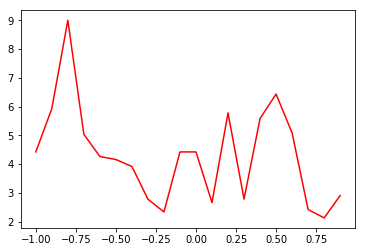

In [8]:
if __name__ == "__main__":
    results = main()
    
    expr = results[2][0]
    
    print(expr)
    
    
    '''PLOTANDO OS GRAFICOS'''
    tree = gp.PrimitiveTree(expr)
    
    candidate_function = toolbox.compile(tree)
    
    
    
    plot(candidate_function)
    
    